In [7]:
#import scrublet as scr
import numpy as np
import pandas as pd
import statistics as st
import re
import csv
import scanpy as sc 
import scanpy.external as sce
import phate
import matplotlib
from matplotlib import pyplot as plt
import warnings
from scipy.stats import binom
from scipy.stats import multinomial
import seaborn as sns
from scipy.stats import hypergeom
import warnings
warnings.filterwarnings('ignore')
import scrublet as scr
import harmonypy as hm
import pickle
from random import sample
from matplotlib_venn import venn2
from _util_updated import cluster_bias

### Load Data

In [2]:
#CM_Cells = sc.read_h5ad('./Large_CM_DF.h5ad')

In [3]:
PATH = '../../Data/Pickles/'
Dict_File = open(PATH + "CM_Large_sgRNA_Dic_Filtered.pkl", "rb")
SGRNA_CELLS_DIC = pickle.load(Dict_File)

In [4]:
PATH = '../../Data/Pickles/'
Dict_File = open(PATH + "Guide_Dictionary_Filtered.pkl", "rb")
Guide_Dictionary = pickle.load(Dict_File)

In [5]:
Clean_NC_Cells = []
[Clean_NC_Cells.extend(SGRNA_CELLS_DIC[i]) for i in Guide_Dictionary['NC']]

[None, None, None, None]

### Promoter Enhancer Dicts

In [7]:
### Enhancer Dic (Do firt. Not all promoters have enhancers)

Target_Name = []
Enhancer_Name = []
for target in Guide_Dictionary.keys():
    try:
        if target.split('_')[1].startswith('ENH'):
            Target_Name.append(target.split('_')[0])
            Enhancer_Name.append(target)
    except:
        continue
        
Enhancer_Set = []
for target in np.unique(Target_Name):
    Target_Set = []
    for target_enh in Enhancer_Name:
        if target_enh.split('_')[0] == target:
            Target_Set.append(target_enh)
    Enhancer_Set.append(Target_Set)
    
ENH_DICT = dict(zip(np.unique(Target_Name), Enhancer_Set))

### Add Missing TBX5 Set from Sean

ENH_DICT['TBX5'] = ['TBXEnh1']
ENH_DICT['TBX5'].append('TBXEnh2')
ENH_DICT['TBX5'].append('TBXEnh3')
ENH_DICT['TBX5'].append('TBXEnh4')
ENH_DICT['TBX5'].append('TBXEnh5')
ENH_DICT['TBX5'].append('TBXEnh6')

In [8]:
### Promoter Dic

Target_Name = []
Promoter_Name = []
for target in Guide_Dictionary.keys():
    try:
        if target.split('_')[0] not in ENH_DICT.keys():
            continue
        if target.split('_')[1].startswith('PROM'):
            Target_Name.append(target.split('_')[0])
            Promoter_Name.append(target)
    except:
        continue
        
Prom_Set = []
for target in np.unique(Target_Name):
    Target_Set = []
    for target_prom in Promoter_Name:
        if target_prom.split('_')[0] == target:
            Target_Set.append(target_prom)
    Prom_Set.append(Target_Set)
    
PROM_DICT = dict(zip(np.unique(Target_Name), Prom_Set))

### Add Missing TBX5 Set from Sean
PROM_DICT['TBX5'].append('TBX5_P1')
PROM_DICT['TBX5'].append('TBX5_P2')
PROM_DICT['TBX5'].append('TBX5_AS1_P1')
PROM_DICT['TBX5'].append('TBX5_AS1_P2')

### Run HyperGeo for CM

In [10]:
tran_matrix = CM_Cells
t_dict = Guide_Dictionary
s_dict = SGRNA_CELLS_DIC

dep_target_values = []
enr_target_values = []
Target_List = []
for target in Guide_Dictionary.keys():
    control_list = Clean_NC_Cells
    if target  == 'NC':
        for nc in Guide_Dictionary[target]:
            Target_List.append(nc)
            CELL_LIST = s_dict[nc]
            nc_controls = []
            for cell in Clean_NC_Cells:
                if cell not in CELL_LIST:
                    nc_controls.append(cell)
            control_list = nc_controls
            dep_clust_values, cluster_list = cluster_bias(target_cells= CELL_LIST, control_cells = control_list, t_matrix=tran_matrix, direction = 'depletion')
            enr_clust_values, cluster_list = cluster_bias(target_cells= CELL_LIST, control_cells = control_list, t_matrix=tran_matrix, direction = 'enrichment')

            dep_target_values.append(dep_clust_values)
            enr_target_values.append(enr_clust_values)
    elif target == 'MALAT1':
        Target_List.append(target)
        CELL_LIST = s_dict[target]
        dep_clust_values, cluster_list = cluster_bias(target_cells= CELL_LIST, control_cells = control_list, t_matrix=tran_matrix, direction = 'depletion')
        enr_clust_values, cluster_list = cluster_bias(target_cells= CELL_LIST, control_cells = control_list, t_matrix=tran_matrix, direction = 'enrichment') 
        dep_target_values.append(dep_clust_values)
        enr_target_values.append(enr_clust_values)
    else:
        Target_List.append(target)
        guide_set = t_dict[target]
        CELL_LIST = []
        [CELL_LIST.extend(s_dict[Target_key]) for Target_key in list(guide_set)]
        dep_clust_values, cluster_list = cluster_bias(target_cells= CELL_LIST, control_cells = control_list, t_matrix=tran_matrix, direction = 'depletion')
        enr_clust_values, cluster_list = cluster_bias(target_cells= CELL_LIST, control_cells = control_list, t_matrix=tran_matrix, direction = 'enrichment') 
        dep_target_values.append(dep_clust_values)
        enr_target_values.append(enr_clust_values)
        
CM_filtered_dep_CM = pd.DataFrame(data = dep_target_values, columns  = tran_matrix.obs.louvain.cat.categories.tolist(), index= Target_List)  
CM_filtered_enr_CM = pd.DataFrame(data = enr_target_values, columns  = tran_matrix.obs.louvain.cat.categories.tolist(), index= Target_List)  

In [14]:
CM_filtered_dep_CM.sort_values(by='0')

,0,1,2,3
NKX2-6_PROM1,3.093924e-09,0.938008,1.000000,0.940823
MALAT1,7.869629e-09,0.905718,0.999975,0.998221
TBXEnh2,1.898255e-08,0.968689,0.999999,0.922506
TBX5_PROM2,4.309917e-08,0.996288,1.000000,0.129605
TBX5_PROM1,3.514680e-07,0.947877,0.999994,0.896635
TGFB1_ENH1,6.642702e-07,0.993784,0.999479,0.899566
TBXEnh3,1.532264e-06,1.000000,0.100837,0.967381
CHDEnh5,2.470320e-05,0.993923,0.996224,0.762840
GATA4_PROM3,6.073179e-05,0.856091,0.999423,0.946293
TBXEnh5,6.164584e-05,0.739322,0.997939,0.998129


In [16]:
CM_filtered_enr_CM.to_pickle('./DAP3_CM_CB_Enriched.pkl')

In [17]:
CM_filtered_dep_CM.to_pickle('./DAP3_CM_CB_Depleted.pkl')

### Plot heatmap of pvals

In [20]:
Depleted_DF = CM_filtered_dep_CM[['2','3', '1', '0']].sort_values('0')

In [21]:
Depleted_Index = CM_filtered_dep_CM[['2','3', '1', '0']].sort_values('0').index

<AxesSubplot:>

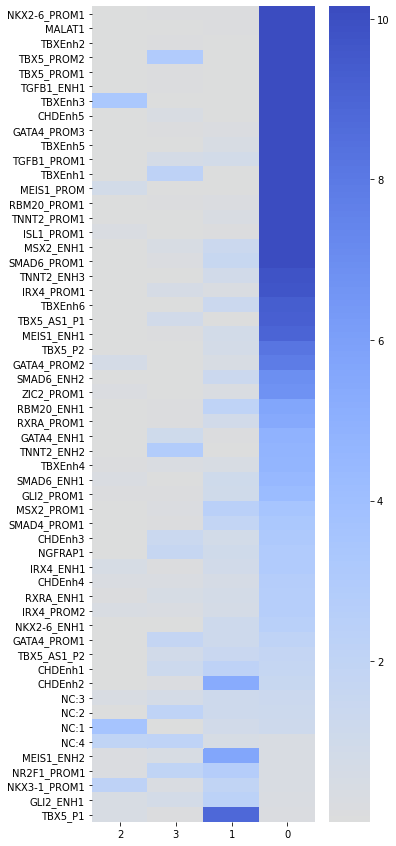

In [22]:
fig, ax = plt.subplots(figsize=(5,15))

sns.heatmap(np.log2(1/Depleted_DF), cmap='coolwarm_r', center = 0, vmax=np.log2(1/(0.05/(57))))
plt.savefig('./CM_PHATE_Dep_072821.pdf')

In [23]:
Enriched_DF = CM_filtered_enr_CM[['2','3', '1', '0']].loc[Depleted_Index]

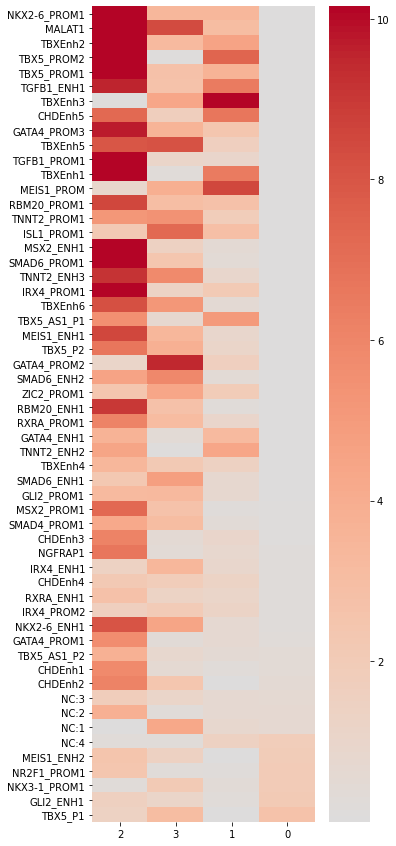

In [48]:
fig, ax = plt.subplots(figsize=(5,15))

sns.heatmap(np.log2(1/Enriched_DF), cmap='coolwarm', center = 0, vmax=np.log2(1/(0.05/(57))))
plt.savefig('./CM_PHATE_Enr_072821.pdf')